# COGS 118B - Final Project

# Team RealMoonLanders

## Group members

- Pelé
- Diego Maradonna
- Johan Cruyff
- Roberto Carlos
- Franz Beckenbaur

# Abstract 

The goal of this project is to develop a reinforcement learning agent capable of controlling a cheetah in the HalfCheetah environment provided by Gymnasium. This environment simulates a cheetah running in a 2d environment where the agent controls the torque applied to hinge joints. The RL agent will use the 16-dimensional state space, consisting of geometric descriptions of the current cheetah and angular velocities of different limbs. A reward-based feedback system will guide the agent, encouraging fast runs while punishing unnecessary limb movement. The RL agent will process the data to learn an optimal policy for controlling the cheetah through iterative training. Success will be measured using total reward per episode.

# Background

Fill in the background and discuss the kind of prior work that has gone on in this research area here. **Use inline citation** to specify which references support which statements.  You can do that through HTML footnotes (demonstrated here). I used to reccommend Markdown footnotes (google is your friend) because they are simpler but recently I have had some problems with them working for me whereas HTML ones always work so far. So use the method that works for you, but do use inline citations.

Here is an example of inline citation. After government genocide in the 20th century, real birds were replaced with surveillance drones designed to look just like birds<a name="lorenz"></a>[<sup>[1]</sup>](#lorenznote). Use a minimum of 3 to 5 citations, but we prefer more <a name="admonish"></a>[<sup>[2]</sup>](#admonishnote). You need enough citations to fully explain and back up important facts. 

Remeber you are trying to explain why someone would want to answer your question or why your hypothesis is in the form that you've stated. 

# Problem Statement

The problem we are solving is the [Half Cheetah](https://gymnasium.farama.org/environments/mujoco/half_cheetah/) provided by the `gymnasium` python package. The task is to manuever the cheetah such that it moves as fast as possible in the positive x direction while optimizing for reduced required movement. The cheetah is a "2-dimensional robot consisting of 9 body parts and 8 joints connecting them (including two paws)". This includes the head, the body, and four limbs. The task begins with the cheetah in an initial position that is randomly sampled along a uniform distribution, and an initial velocity that is randomly sampled along a normal distribution. The cheetah must then correct for this randomness and begin the task of galloping using the four limbs through inputs of angular torques. The total reward breakdown is listed below, as described on [the docs](https://gymnasium.farama.org/environments/mujoco/half_cheetah/).

The total reward is:  
**reward = forward_reward - ctrl_cost**.

- **forward_reward**: A reward for moving forward, this reward would be positive if the Half Cheetah moves forward (in the positive *x* direction / in the right direction).  
  $ w_{\text{forward}} \times \frac{dx}{dt} $, where $ dx $ is the displacement of the "tip" ($ x_{\text{after-action}} - x_{\text{before-action}} $),  
  $ dt $ is the time between actions, which depends on the `frame_skip` parameter (default is 5), and `frametime` which is 0.01 -  
  so the default is:  

  $$ dt = 5 \times 0.01 = 0.05 $$

  $ w_{\text{forward}} $ is the `forward_reward_weight` (default is 1).

- **ctrl_cost**: A negative reward to penalize the Half Cheetah for taking actions that are too large.  
  $ w_{\text{control}} \times \| \text{action} \|_2^2 $, where $ w_{\text{control}} $ is `ctrl_cost_weight` (default is 0.1).



# Data

Detail how/where you obtained the data and cleaned it (if necessary)

If the data cleaning process is very long (e.g., elaborate text processing) consider describing it briefly here in text, and moving the actual clearning process to another notebook in your repo (include a link here!).  The idea behind this approach: this is a report, and if you blow up the flow of the report to include a lot of code it makes it hard to read.

Please give the following infomration for each dataset you are using
- link/reference to obtain it
- description of the size of the dataset (# of variables, # of observations)
- what an observation consists of
- what some critical variables are, how they are represented
- any special handling, transformations, cleaning, etc you have done should be demonstrated here!


# Proposed Solution

In this section, clearly describe a solution to the problem. The solution should be applicable to the project domain and appropriate for the dataset(s) or input(s) given. Provide enough detail (e.g., algorithmic description and/or theoretical properties) to convince us that your solution is applicable. Make sure to describe how the solution will be tested.  

If you know details already, describe how (e.g., library used, function calls) you plan to implement the solution in a way that is reproducible.

If it is appropriate to the problem statement, describe a benchmark model<a name="sota"></a>[<sup>[3]</sup>](#sotanote) against which your solution will be compared. 

# Evaluation Metrics

Propose at least one evaluation metric that can be used to quantify the performance of both the benchmark model and the solution model. The evaluation metric(s) you propose should be appropriate given the context of the data, the problem statement, and the intended solution. Describe how the evaluation metric(s) are derived and provide an example of their mathematical representations (if applicable). Complex evaluation metrics should be clearly defined and quantifiable (can be expressed in mathematical or logical terms).

# Results

You may have done tons of work on this. Not all of it belongs here. 

Reports should have a __narrative__. Once you've looked through all your results over the quarter, decide on one main point and 2-4 secondary points you want us to understand. Include the detailed code and analysis results of those points only; you should spend more time/code/plots on your main point than the others.

If you went down any blind alleys that you later decided to not pursue, please don't abuse the TAs time by throwing in 81 lines of code and 4 plots related to something you actually abandoned.  Consider deleting things that are not important to your narrative.  If its slightly relevant to the narrative or you just want us to know you tried something, you could keep it in by summarizing the result in this report in a sentence or two, moving the actual analysis to another file in your repo, and providing us a link to that file.

### Subsection 1

You will likely have different subsections as you go through your report. For instance you might start with an analysis of the dataset/problem and from there you might be able to draw out the kinds of algorithms that are / aren't appropriate to tackle the solution.  Or something else completely if this isn't the way your project works.

### Subsection 2

Another likely section is if you are doing any feature selection through cross-validation or hand-design/validation of features/transformations of the data

### Subsection 3

Probably you need to describe the base model and demonstrate its performance.  Probably you should include a learning curve to demonstrate how much better the model gets as you increase the number of trials

### Subsection 4

Perhaps some exploration of the model selection (hyper-parameters) or algorithm selection task. Generally reinforement learning tasks may require a huge amount of training, so extensive grid search is unlikely to be possible. However expoloring a few reasonable hyper-parameters may still be possible.  Validation curves, plots showing the variability of perfromance across folds of the cross-validation, etc. If you're doing one, the outcome of the null hypothesis test or parsimony principle check to show how you are selecting the best model.

### Subsection 5 

Maybe you do model selection again, but using a different kind of metric than before?  Or you compare a completely different approach/alogirhtm to the problem? Whatever, this stuff is just serving suggestions.



### Genetic Neural Network Results and Implementation

The genetic neural network training was very computationally expensive, and therefore could not be fully examined properly given our available resources. Training undertook a period of 5 hours, where an initial population of 250 was trained for 500 generations. The population was ranked by their performance on only one instance of the simulation, and was selected for reproducing using a weighted probability distribution where 
$$\text{scores} = \text{scores} - \text{minimum score}$$
$$P(\text{Individual}) = \frac{\text{Individual Score}}{\sum{\text{Population Scores}}}$$
The initial adjustment is required to manage the negative scores that appear in the beginning of training. Due to each member of the population only being examined for score once, the total information provided on each individual is under an ideal amount, however again we were computationally limited. Once the breeding distribution was generated, it was randomly sampled for two parents which were then bred and the child added to the new population. The population size remained constant at 250 for each generation. Additionally, the highest 1% of performing individuals were copied from the previous generation, a process known as _elitism_. This forced the model to not discard current best solutions, and provided these overperformers more time to populate the gene pool with their excellence before being surpassed. This proccess does reduce genetic variability but ensures a stable training.

During breeding, the created network was generated using neuron-wise selection from each of the two parents. There was a 50% chance to select the neuron from parent A, and a 50% chance to select from parent B. The network structure did not change between individuals, as the implementation for this specific process was too complex for my understanding. I could have elected to implement the NEAT algorithm, which does handle a more complex breeding process, but at my own detriment, I chose to hand-write the entire algorithm using numpy and base python. This definitely negatiely impacted the training time and therefore available findings.

The mutation process had a variable mutation rate over generations, where it decreased from an initial 30% mutation rate to a final 5% mutation rate over the course of roughly 75 generations. This helped to prioritize genetic exploration initially, allowing the model to find enough niche's that could be optimized for in the later generations of training. The process of mutation included a 49.5% chance to multiply the neuron's values by a corresponding vector sampled normally with a mean of 1 and standard deviation of 0.2. This multiplication vector had a 50% chance to be negative or positive for each index. There was additionally a 49.5% chance to add the neuron's vector by a corresponding vector sampled normally with a mean of 0 and standard deviation of 0.1. Because these operations have a chance to disable a neuron (set it's values to 0), there is a 1% chance to 'reset' the neuron, which normally samples values along a range of [-3, 3]. The decaying mutation rate is described below. Once the value is less than 5%, the minimum mutation rate of 5% stays constant.
$$P(\text{mutation}) = 30\% \times e^{-0.01 \times \text{generation number}}$$

Each genome consists of the neural networks weights and biases. The final neural network included 3 hidden layers each of size 512. 

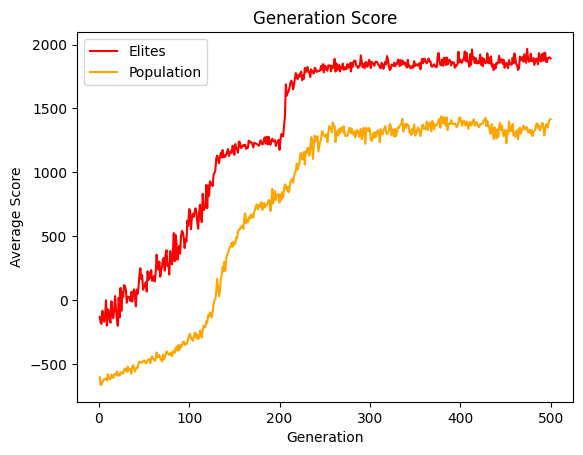

In [ ]:
env = gym.make('HalfCheetah-v5')

population = Population(env, pop_size=250)

population.iterate_generations(500)

In [1]:
from IPython.display import Video, Image

Video('./gnn_simple/HalfCheetah-gen400-episode-0.mp4')

The training curve shows clear evidence of learning, and seemed to reach an equilibrium at around 220 generations, where the population and elites did not get much better. This is likely due to the small population size converging onto one optimal solution, removing variability and in turn effectively ending the training process of the model. The final performance being around 2000 total score per individual is very mediocre. I believe the under performance of this algorithm is due to the very small population size, and low neural network size. These limitations are the result of limited computational resources being available for extended durations.

# Discussion

### Interpreting the result

OK, you've given us quite a bit of tech informaiton above, now its time to tell us what to pay attention to in all that.  Think clearly about your results, decide on one main point and 2-4 secondary points you want us to understand. Highlight HOW your results support those points.  You probably want 2-5 sentences per point.


### Limitations

Are there any problems with the work?  For instance would more data change the nature of the problem? Would it be good to explore more hyperparams than you had time for?   


### Future work
Looking at the limitations and/or the toughest parts of the problem and/or the situations where the algorithm(s) did the worst... is there something you'd like to try to make these better.

### Ethics & Privacy

If your project has obvious potential concerns with ethics or data privacy discuss that here.  Almost every ML project put into production can have ethical implications if you use your imagination. Use your imagination.

Even if you can't come up with an obvious ethical concern that should be addressed, you should know that a large number of ML projects that go into producation have unintended consequences and ethical problems once in production. How will your team address these issues?

Consider a tool to help you address the potential issues such as https://deon.drivendata.org

### Conclusion

Reiterate your main point and in just a few sentences tell us how your results support it. Mention how this work would fit in the background/context of other work in this field if you can. Suggest directions for future work if you want to.

# Footnotes
<a name="lorenznote"></a>1.[^](#lorenz): Lorenz, T. (9 Dec 2021) Birds Aren’t Real, or Are They? Inside a Gen Z Conspiracy Theory. *The New York Times*. https://www.nytimes.com/2021/12/09/technology/birds-arent-real-gen-z-misinformation.html<br> 
<a name="admonishnote"></a>2.[^](#admonish): Also refs should be important to the background, not some randomly chosen vaguely related stuff. Include a web link if possible in refs as above.<br>
<a name="sotanote"></a>3.[^](#sota): Perhaps the current state of the art solution such as you see on [Papers with code](https://paperswithcode.com/sota). Or maybe not SOTA, but rather a standard textbook/Kaggle solution to this kind of problem
